# P3. Redes Neuronales con CNN - Clasificación de Dígitos

## Objetivo del Proyecto
### En este notebook se desarrollará un pipeline completo para la clasificación de dígitos manuscritos (0–9) usando redes neuronales convolucionales en Python. 

### 1. Se cubrirán los siguientes pasos:
### 2. Carga de imágenes desde directorios organizados por clase.
### 3. Definición, entrenamiento y validación de una CNN básica.
### 4. Experimentación con al menos 5 variantes de arquitectura/hiperparámetros.
### 5. Selección del mejor modelo y visualización de sus curvas de aprendizaje.
### 6. Evaluación final en el conjunto de test con matriz de confusión.
### 7. Exportación, carga y demo en tiempo real con cámara.
### 8. Integración en un mini-sistema OCR con procesamiento de contornos.

### Cada sección está documentada en Markdown y organizada en celdas independientes para facilitar la lectura y replicación.

# 1) Carga de datos con ImageDataGenerator y flow_from_directory

Found 4549 images belonging to 10 classes.
Found 1132 images belonging to 10 classes.
Found 1615 images belonging to 10 classes.


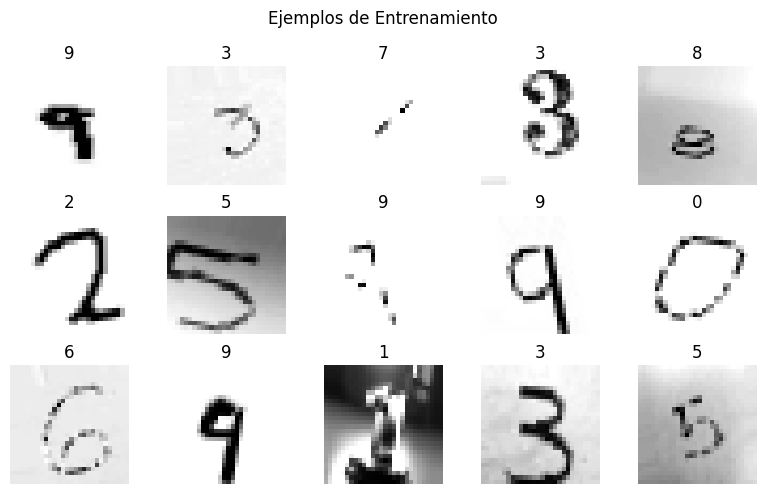

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directorios de trabajo
base_dir = 'dataset/'  # Contiene subfolders 'train/' y 'test/' con subfolders '0'-'9'
train_dir = os.path.join(base_dir, 'train')
test_dir  = os.path.join(base_dir, 'test')

# Augmenter con split para validación automática
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    shear_range=10,
    brightness_range=[0.7,1.3],
    validation_split=0.2
)

# Generadores para entrenamiento y validación
flow_params = dict(
    target_size=(28, 28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32
)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    subset='training',
    shuffle=True,
    **flow_params
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    subset='validation',
    shuffle=False,
    **flow_params
)

# Generador para test
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    shuffle=False,
    **flow_params
)

# Mostrar un lote de ejemplos (con class_mode='categorical')
imgs, labels = next(train_gen)

fig, axes = plt.subplots(3, 5, figsize=(8, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[i].squeeze(), cmap='gray')
    # Convertir one-hot a entero:
    digit = np.argmax(labels[i])
    ax.set_title(digit)
    ax.axis('off')

plt.suptitle('Ejemplos de Entrenamiento')
plt.tight_layout()
plt.show()

## 2. Definición de la arquitectura CNN básica
### Explicación de la arquitectura:
### - Conv2D(32,3x3) + ReLU
### - MaxPooling 2x2
### - Conv2D(64,3x3) + ReLU
### - MaxPooling 2x2
### - Flatten
### - Dense(128) + ReLU + Dropout
### - Dense(10) + Softmax

### Las salidas de cada capa tienen dimensiones:
### Input: 28x28x1
### Conv1: 26x26x32
### Pool1: 13x13x32
### Conv2: 11x11x64
### Pool2: 5x5x64
### Flatten: 1600
### Dense: 128
### Output: 10

In [3]:
# This takes minutes to run
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model_base = Sequential([
    Conv2D(32,(3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax') # 10 outputs, one-hot encoded.
])

model_base.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_base = model_base.fit(train_gen, epochs=10, validation_data=val_gen)


Epoch 1/10


143/143 [==============================] - 68s 472ms/step - loss: 2.2476 - accuracy: 0.1537 - val_loss: 2.1093 - val_accuracy: 0.3242
Epoch 2/10
143/143 [==============================] - 25s 178ms/step - loss: 1.9198 - accuracy: 0.3381 - val_loss: 1.8173 - val_accuracy: 0.4355
Epoch 3/10
143/143 [==============================] - 26s 181ms/step - loss: 1.6410 - accuracy: 0.4456 - val_loss: 1.6141 - val_accuracy: 0.5415
Epoch 4/10
143/143 [==============================] - 29s 204ms/step - loss: 1.4631 - accuracy: 0.5144 - val_loss: 1.4591 - val_accuracy: 0.5618
Epoch 5/10
143/143 [==============================] - 28s 197ms/step - loss: 1.3694 - accuracy: 0.5485 - val_loss: 1.4026 - val_accuracy: 0.5813
Epoch 6/10
143/143 [==============================] - 27s 185ms/step - loss: 1.2663 - accuracy: 0.5953 - val_loss: 1.2965 - val_accuracy: 0.6078
Epoch 7/10
143/143 [==============================] - 26s 183ms/step - loss: 1.1924 - accuracy: 0.6195 - val_loss: 1.3712 - val

## 3. Experimentación con variantes de arquitectura (5 modelos adicionales)

### M1. Más filtros en la primera capa (64, 32)  
En esta variante se incrementa el número de filtros en las dos primeras capas convolucionales, pasando de (32, 64) a (64, 32). El propósito es dotar a la red de una mayor capacidad para extraer patrones locales al inicio del procesamiento, capturando texturas y detalles finos desde el primer bloque, y luego reducir ligeramente el número de filtros en el segundo bloque para controlar el número de parámetros totales. Se espera que este ajuste mejore la sensibilidad a trazos sutiles sin incurrir en un crecimiento desmesurado del coste computacional.

### M2. Añadir BatchNormalization tras cada convolución  
Este modelo introduce una capa de **BatchNormalization** inmediatamente después de cada operación de convolución. La normalización por lotes estabiliza la distribución de activaciones durante el entrenamiento, acelera la convergencia y actúa como una ligera forma de regularización, reduciendo la dependencia de una inicialización muy precisa y permitiendo tasas de aprendizaje más agresivas.

### M3. Añadir capa Conv3 adicional (128 filtros)  
Para explorar redes más profundas, se incorpora un tercer bloque convolucional con 128 filtros de tamaño 3×3 seguido de su correspondiente capa de pooling. Esta configuración busca aumentar la profundidad de la red, permitiendo la extracción de características de orden superior y patrones más complejos, al tiempo que el pooling reduce progresivamente la resolución espacial para concentrar la información más relevante.

### M4. Probar optimizador RMSprop  
En lugar de Adam, este experimento emplea **RMSprop**, un optimizador que adapta la tasa de aprendizaje basándose en una media móvil de la magnitud de los gradientes pasados. RMSprop tiende a funcionar muy bien en problemas de visión con ruido en el gradiente y puede ofrecer una convergencia más suave en redes relativamente profundas, aunque a costa de un ajuste cuidadoso de su hiperparámetro de aprendizaje.

### M5. Variar dropout (0.5)  
Finalmente, se ajusta la tasa de **Dropout** al 50 % en la capa densa final, frente al 30 % empleado originalmente. Con una probabilidad más alta de desactivar unidades durante cada paso de entrenamiento, se fuerza a la red a distribuir el aprendizaje de forma más uniforme entre todas las neuronas, lo que puede resultar en una mayor robustez frente al sobreajuste, especialmente en conjunto de datos de tamaño limitado.

In [4]:
from tensorflow.keras.optimizers import RMSprop
variants = []
# Definir función para crear modelo según parámetro

def make_model(cfg):
    m = Sequential()
    m.add(Conv2D(cfg['f1'],(3,3),activation='relu',input_shape=(28,28,1)))
    if cfg.get('bn1'): m.add(BatchNormalization())
    m.add(MaxPooling2D((2,2)))
    m.add(Conv2D(cfg['f2'],(3,3),activation='relu'))
    if cfg.get('bn2'): m.add(BatchNormalization())
    m.add(MaxPooling2D((2,2)))
    if cfg.get('conv3'):
        m.add(Conv2D(cfg['f3'],(3,3),activation='relu'))
        if cfg.get('bn3'): m.add(BatchNormalization())
        m.add(MaxPooling2D((2,2)))
    m.add(Flatten())
    m.add(Dense(128, activation='relu'))
    m.add(Dropout(cfg['drop']))
    m.add(Dense(10, activation='softmax'))
    opt = cfg.get('opt','adam')
    if opt=='rms': m.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])
    else:     m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return m

configs = [
    {'name':'M1','f1':64,'f2':32,'drop':0.3},
    {'name':'M2','f1':32,'f2':64,'bn1':True,'bn2':True,'drop':0.3},
    {'name':'M3','f1':32,'f2':64,'conv3':True,'f3':128,'drop':0.3},
    {'name':'M4','f1':32,'f2':64,'drop':0.3,'opt':'rms'},
    {'name':'M5','f1':32,'f2':64,'drop':0.5}
]

results = {}
for cfg in configs:
    print(f"Entrenando {cfg['name']}")
    m = make_model(cfg)
    h = m.fit(train_gen, epochs=10, validation_data=val_gen, verbose=0)
    val_acc = h.history['val_accuracy'][-1]
    results[cfg['name']] = {'model':m,'history':h,'val_acc':val_acc}
    print(f"{cfg['name']} val_acc: {val_acc:.4f}")

# Elegir mejor por val_acc
best_name = max(results, key=lambda k: results[k]['val_acc'])
print(f"Mejor modelo: {best_name} con val_acc {results[best_name]['val_acc']:.4f}")
model_best = results[best_name]['model']
history_best = results[best_name]['history']


Entrenando M1
M1 val_acc: 0.6440
Entrenando M2
M2 val_acc: 0.6175
Entrenando M3
M3 val_acc: 0.6564
Entrenando M4
M4 val_acc: 0.6405
Entrenando M5
M5 val_acc: 0.6299
Mejor modelo: M3 con val_acc 0.6564


## 4. Gráficas de aprendizaje del modelo ganador

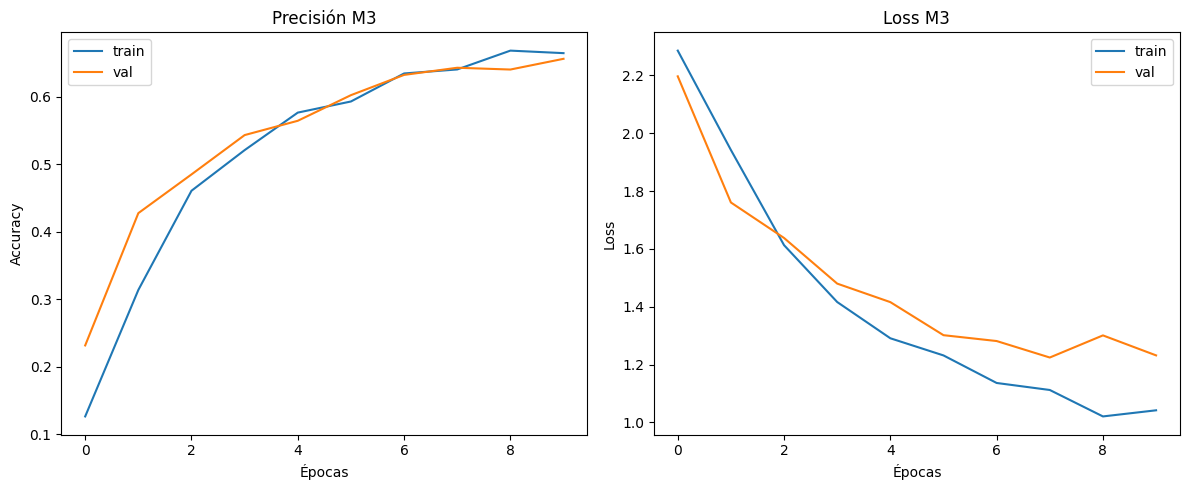

Conclusiones: describe curvas, over/underfitting, etc.


In [5]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_best.history['accuracy'], label='train')
plt.plot(history_best.history['val_accuracy'], label='val')
plt.title(f'Precisión {best_name}')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_best.history['loss'], label='train')
plt.plot(history_best.history['val_loss'], label='val')
plt.title(f'Loss {best_name}')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print("Conclusiones: describe curvas, over/underfitting, etc.")


## 5. Entrenar con todo el training set y evaluar en test, combinar train + val generadores para re-entrenar

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1) Create a new datagen that only rescales
full_train_datagen = ImageDataGenerator(rescale=1./255)

# 2) Point it at your train/ folder (no subset argument)
full_train_gen = full_train_datagen.flow_from_directory(
    train_dir,              # e.g. 'data/digits/train'
    target_size=(28,28),
    color_mode='grayscale',
    class_mode='categorical',  # or 'sparse' if you changed your loss accordingly
    batch_size=32,
    shuffle=True
)

# 3) Re-train your best model on this full generator
model_final = make_model(configs[[c['name'] for c in configs].index(best_name)])
model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_final.fit(full_train_gen, epochs=10)

# 4) Evaluate on test (unchanged)
test_loss, test_acc = model_final.evaluate(test_gen)
print(f"Test accuracy: {test_acc:.4f}")

# 5) (Optional) Compute confusion matrix as before
y_true = test_gen.classes
y_pred = np.argmax(model_final.predict(test_gen), axis=1)
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

Found 5681 images belonging to 10 classes.
Epoch 1/10
178/178 [==============================] - 25s 137ms/step - loss: 1.9583 - accuracy: 0.2970
Epoch 2/10
178/178 [==============================] - 27s 152ms/step - loss: 1.0949 - accuracy: 0.6532
Epoch 3/10
178/178 [==============================] - 25s 143ms/step - loss: 0.8387 - accuracy: 0.7481
Epoch 4/10
178/178 [==============================] - 27s 153ms/step - loss: 0.7116 - accuracy: 0.7842
Epoch 5/10
178/178 [==============================] - 27s 149ms/step - loss: 0.5820 - accuracy: 0.8256
Epoch 6/10
178/178 [==============================] - 23s 132ms/step - loss: 0.5227 - accuracy: 0.8370
Epoch 7/10
178/178 [==============================] - 24s 134ms/step - loss: 0.4551 - accuracy: 0.8641
Epoch 8/10
178/178 [==============================] - 24s 134ms/step - loss: 0.4048 - accuracy: 0.8736
Epoch 9/10
178/178 [==============================] - 23s 130ms/step - loss: 0.3631 - accuracy: 0.8863
Epoch 10/10
51/51 [===========

## 6. Guardar modelo y demo en tiempo real con probabilidades coloreadas.

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# 1) Carga del modelo
model_path = 'digit_cnn_final.h5'
if os.path.exists(model_path):
    print(f"Cargando modelo desde '{model_path}'...")
    model_final = load_model(model_path)
else:
    print(f"Modelo no encontrado en '{model_path}.'")

    # Salvado del modelo entrenado
    model_final.save(model_path)
    print(f"Modelo entrenado y guardado en '{model_path}'.")

# 2) Prepara CLAHE y tabla de corrección gamma
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gamma = 1.2
inv_gamma = 1.0 / gamma
gamma_table = np.array([(i / 255.0) ** inv_gamma * 255 
                        for i in np.arange(0, 256)]).astype("uint8")

# 3) Inicia captura
cap = cv2.VideoCapture(1)
print("Presiona 'q' para salir")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # —————————— PREPROCESAMIENTO ——————————
    # a) Corrección gamma para estabilizar exposición
    frame = cv2.LUT(frame, gamma_table)

    # b) Escala de grises + CLAHE para contraste local
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = clahe.apply(gray)

    # c) Filtrado bilateral para suavizar sin perder bordes
    gray = cv2.bilateralFilter(gray, d=9, sigmaColor=75, sigmaSpace=75)

    # d) Segmentación mediante umbral adaptativo
    th = cv2.adaptiveThreshold(gray, 255, 
                               cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV,
                               blockSize=11, C=2)

    # e) Cierra huecos pequeños
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=1)

    # f) Encontrar contornos y quedarnos con el más grande
    cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if cnts:
        c = max(cnts, key=cv2.contourArea)
        x,y,w,h = cv2.boundingRect(c)
        if w*h > 2000 and h > 20:
            # Añadimos un poco de padding y forzamos ROI cuadrado
            pad = 5
            x1, y1 = max(x-pad,0), max(y-pad,0)
            x2 = min(x+w+pad, frame.shape[1])
            y2 = min(y+h+pad, frame.shape[0])
            roi = th[y1:y2, x1:x2]

            # centrar en canvas cuadrado
            size = max(roi.shape)
            canvas = np.zeros((size,size), dtype=roi.dtype)
            dx = (size - roi.shape[1]) // 2
            dy = (size - roi.shape[0]) // 2
            canvas[dy:dy+roi.shape[0], dx:dx+roi.shape[1]] = roi

            # Redimensionar y normalizar
            img28 = cv2.resize(canvas, (28,28), cv2.INTER_AREA)
            inp = (img28.astype('float32')/255.0).reshape(1,28,28,1)

            # —————————— PREDICCIÓN ——————————
            preds = model_final.predict(inp)[0]
            digit = np.argmax(preds)
            prob  = np.max(preds)

            # Dibujar resultados
            cv2.rectangle(frame, (x1,y1), (x2,y2), (0,255,0), 2)
            cv2.putText(frame, f'{digit} {prob:.2f}', 
                        (x1, y1-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

    # 4) Mostrar ventanas
    cv2.imshow('Segmentación', th)
    cv2.imshow('Reconocimiento', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Cargando modelo desde 'digit_cnn_final.h5'...
Presiona 'q' para salir
1/1 [==============================] - 0s 22ms/step


## 7. Mini-sistema OCR con contornos

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import os

def ocr_imagen_estatica(image_path,
                        model_path='digit_cnn_final.h5',
                        max_dim=600,
                        min_area=400,               
                        max_area_ratio=0.8,
                        min_aspect=0.2,              
                        max_aspect=5.0,              
                        solidity_thresh=0.1,         
                        prob_threshold=0.5):        
    # 1) Carga del modelo
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Modelo no encontrado en '{model_path}'")
    model = load_model(model_path)

    # 2) Leer y escalar imagen grande
    img_color = cv2.imread(image_path)
    if img_color is None:
        raise FileNotFoundError(f"No se pudo leer '{image_path}'")
    h_img, w_img = img_color.shape[:2]
    if max(h_img, w_img) > max_dim:
        scale = max_dim / float(max(h_img, w_img))
        img_color = cv2.resize(img_color,
                               (int(w_img * scale), int(h_img * scale)),
                               interpolation=cv2.INTER_AREA)

    # 3) Corrección de iluminación
    # 3.1) Corrección gamma ligera
    gamma = 1.1
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    img_color = cv2.LUT(img_color, table)
    # 3.2) CLAHE
    gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)

    # 4) Reducción de ruido y segmentación
    blur = cv2.GaussianBlur(gray, (1, 1), 0)
    thresh = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=15, C=3
    )
    # Opening para eliminar puntos muy pequeños
    kernel_open = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_open, iterations=1)
    # Closing para unir trazos
    kernel_close = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    processed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel_close, iterations=1)

    # 5) Encontrar contornos externos
    cnts, _ = cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 6) Filtrar e iterar contornos
    img_out = img_color.copy()
    img_area = img_color.shape[0] * img_color.shape[1]
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        area = w * h
        aspect = h / float(w + 1e-5)
        solidity = cv2.contourArea(c) / float(area)

        if area < min_area or area > img_area * max_area_ratio:
            continue
        if aspect < min_aspect or aspect > max_aspect:
            continue
        if solidity < solidity_thresh:
            continue

        # 6.1) Extraer y centrar ROI
        roi = processed[y:y+h, x:x+w]
        L = max(w, h)
        canvas = np.zeros((L, L), dtype=roi.dtype)
        dx = (L - w) // 2
        dy = (L - h) // 2
        canvas[dy:dy+h, dx:dx+w] = roi

        # 6.2) Redimensionar y normalizar
        img28 = cv2.resize(canvas, (28, 28), interpolation=cv2.INTER_AREA)
        inp = img28.astype('float32') / 255.0
        inp = inp.reshape(1, 28, 28, 1)

        # 7) Predicción y filtrado por confianza
        preds = model.predict(inp)[0]
        digit = np.argmax(preds)
        prob  = np.max(preds)
        if prob < prob_threshold:
            continue

        # 8) Dibujar resultados
        cv2.rectangle(img_out, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(
            img_out,
            f"{digit} ({prob:.2f})",
            (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.9,
            (0, 255, 0),
            2
        )

    # 9) Mostrar resultado
    cv2.imshow("OCR Estático - Ajustado", img_out)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


# Ejemplo de uso:
ocr_imagen_estatica("numeros.png", model_path="digit_cnn_final.h5")


1/1 [==============================] - 0s 21ms/step


: 

## <b>Código de honor:</b> Doy mi palabra de que he realizado esta actividad con integridad académica.